# Fundamentos de analítica 2 
# Parcial Final

## Alejandra Ruiz
## Juan Camilo Vergara Arenas
## Universidad ICESI

## **Parcial final**

### Instrucciones
El examen se compone de dos partes:
- La primera corresponde a una parte de selección múltiple con 19 preguntas que se responderán en el salón de clase en 45 minutos. Esa primera parte tiene una calificación de 1 a 5.
-La segunda parte corresponde a la parte práctica del examen y tiene también una calificación de 1 a 5.

- La nota de este examen parcial corresponderá al promedio ponderado de las dos notas, donde la parte práctica tiene un peso de 40 % y la parte de selección múltiple de 60 %.
- Usted tiene hasta el 30 de agosto a las 12:00 pm para enviar los archivos por correo, estos archivos deben tener su nombre.
- Sólo se calificaran exámenes en formato pdf. Cualquier otro formato no será tenido en cuenta.
- El examen debe estar acompañado de un notebook (ipynb)  que incluya todo los códigos de python que se emplean para obtener sus resultados.
- El nombre del archivo debe tener su nombre. No se recibirán archivos en otro formato.
- Esta parte del examen es para realizar en casa y debe reflejar el trabajo individual.

### El Problema

En días recientes trabajamos con una compañía de comestibles que estaba interesada en predecir el comportamiento de las ventas (en unidades) de sus dos productos estrella. Fuimos contratados para generar un modelo que permita pronosticar las ventas del siguiente mes de cada uno de esos dos productos. La base de datos disponible en el archivo Examen.csv tiene la información de cada uno de los productos desde enero de 2008.

Su misión es encontrar el mejor modelo para pronosticar cada una de las series. Usted debe entregar un informe escrito de no más de cuatro páginas que presente los resultados al cliente y cuente el proceso para llegar a los pronósticos. Vea las instrucciones para asegurar que entrega los archivos requeridos




## **1. Carga de paquetes**

In [3]:
pip install bayesian-optimization

Note: you may need to restart the kernel to use updated packages.Collecting bayesian-optimization
  Using cached bayesian_optimization-1.5.1-py3-none-any.whl.metadata (16 kB)
Using cached bayesian_optimization-1.5.1-py3-none-any.whl (28 kB)




[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\aleja\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
import statsmodels.api as sm 
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import GridSearchCV
import itertools
import random

## **2. Carga de datos**


In [3]:
# Cargar los datos desde el archivo CSV
data = pd.read_csv("Examen.csv")

# Renombrar la primera columna a 'Fecha'
data.rename(columns={data.columns[0]: 'Fecha'}, inplace=True)

# Convertir la columna 'Fecha' en formato de fecha
# Suponiendo que los valores en 'Fecha' son días a partir del 1 de enero de 2023
data['Fecha'] = pd.to_datetime(data['Fecha'], unit='D', origin='2013-01-01')

# Establecer la columna 'Fecha' como índice
data.set_index('Fecha', inplace=True)

data.head()

,producto1,producto2
Fecha,,
2013-01-02,4000.000000,3000.000000
2013-01-03,3997.400893,3010.686220
2013-01-04,3978.605317,3022.018584
2013-01-05,3986.454125,3033.920990
2013-01-06,3979.695678,3038.402098


### **2.1. Descripción de los datos**

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 2013-01-02 to 2013-05-08
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   producto1  127 non-null    float64
 1   producto2  127 non-null    float64
dtypes: float64(2)
memory usage: 3.0 KB


In [4]:
# Separar los datos en dos DataFrames, uno para cada producto
data_producto1 = data[['producto1']]
data_producto2 = data[['producto2']]

In [4]:
# Mostrar los DataFrames separados
data_producto1.head()

,producto1
Fecha,
2013-01-02,4000.000000
2013-01-03,3997.400893
2013-01-04,3978.605317
2013-01-05,3986.454125
2013-01-06,3979.695678


In [17]:
df_describe = pd.DataFrame()
df_describe['producto1'] = data_producto1.describe()
df_describe['producto2'] = data_producto2.describe()

In [18]:
df_describe

,producto1,producto2
count,127.000000,127.000000
mean,3843.571660,3381.037664
std,100.234821,167.504363
min,3637.047639,3000.000000
25%,3756.853812,3269.194001
50%,3840.644019,3426.048401
75%,3950.071775,3508.941718
max,4000.000000,3606.440615


In [5]:
# Mostrar los DataFrames separados
data_producto2.head()

,producto2
Fecha,
2013-01-02,3000.000000
2013-01-03,3010.686220
2013-01-04,3022.018584
2013-01-05,3033.920990
2013-01-06,3038.402098


### **2.2. Visualizaciones Generales**

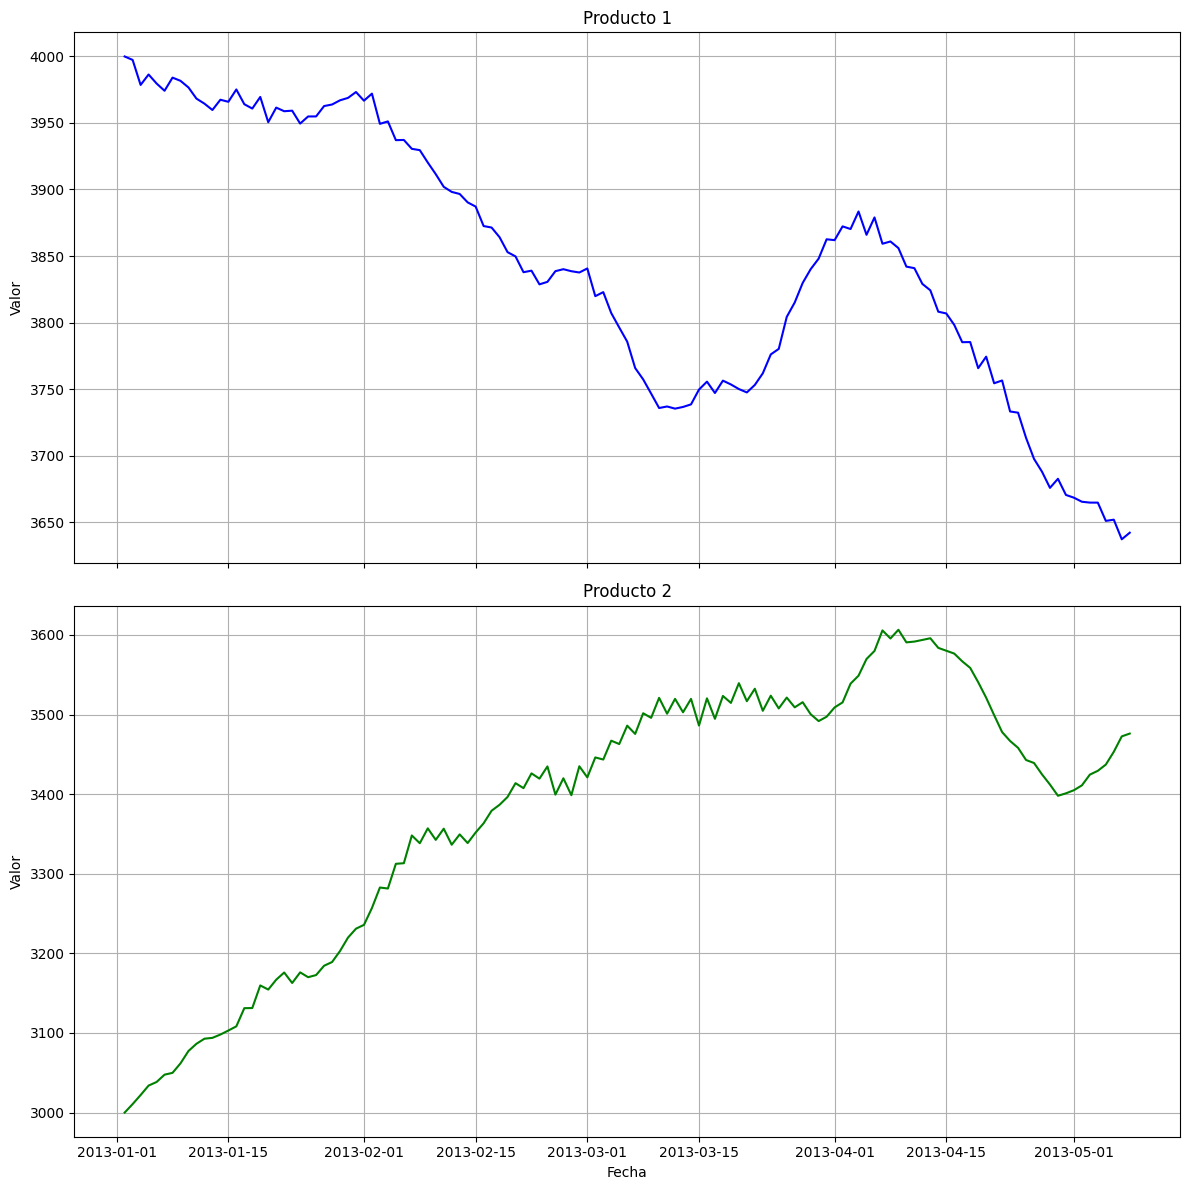

In [6]:
# Crear una figura con dos subplots verticales
fig, axs = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# Graficar producto1 en el primer subplot
axs[0].plot(data_producto1.index, data_producto1['producto1'], color='blue')
axs[0].set_title('Producto 1')
axs[0].set_ylabel('Valor')
axs[0].grid()

# Graficar producto2 en el segundo subplot
axs[1].plot(data_producto2.index, data_producto2['producto2'], color='green')
axs[1].set_title('Producto 2')
axs[1].set_xlabel('Fecha')
axs[1].set_ylabel('Valor')
axs[1].grid()

# Ajustar el diseño y mostrar las gráficas
fig.tight_layout()
plt.show()

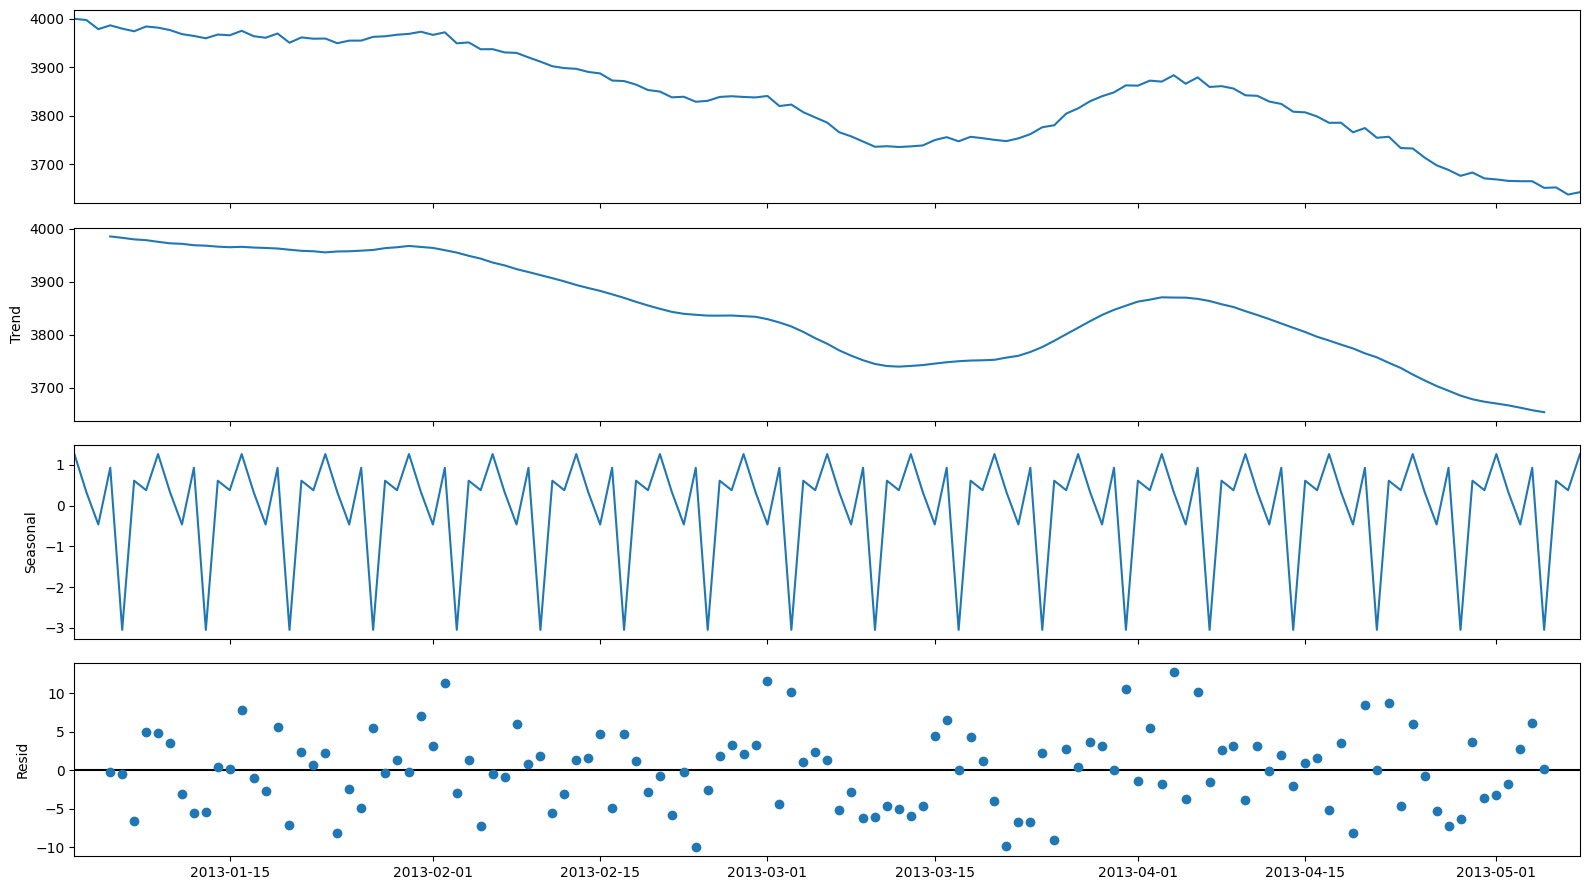

In [7]:
td_componentes1 = seasonal_decompose(data_producto1,model="additive")
fig = td_componentes1.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

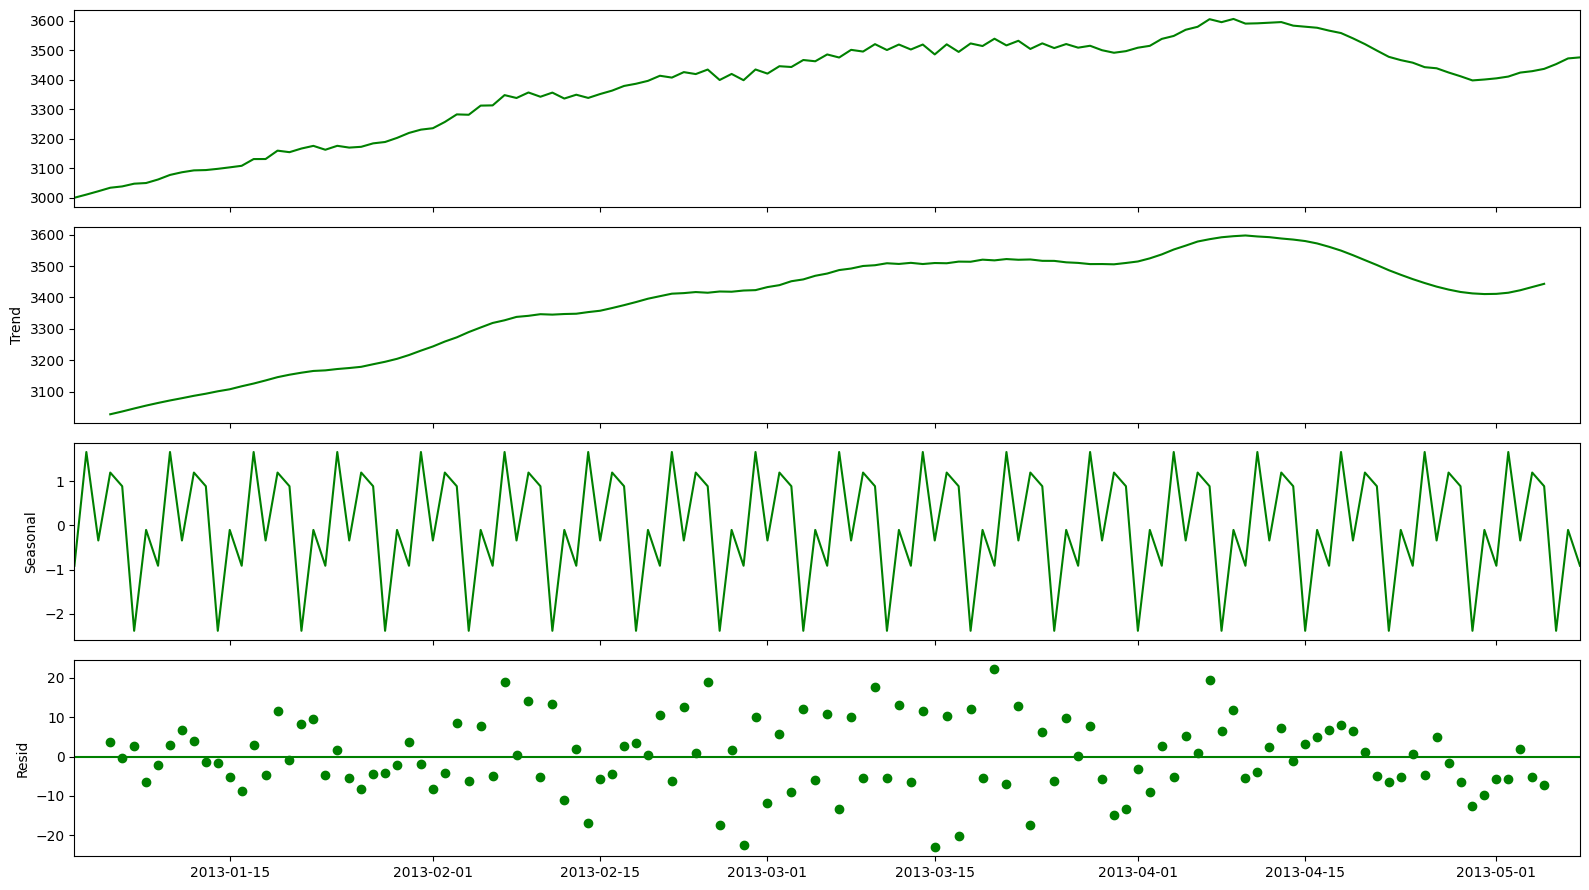

In [13]:
td_componentes2 = seasonal_decompose(data_producto2,model="additive")
fig = td_componentes2.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
for ax in fig.axes:
    for line in ax.get_lines():
        line.set_color("green")
plt.show()

## **3. MODELAMIENTO**

## **3.1. Protocolo de Evaluación - Ventana Móvil**

In [37]:
def protocolo(df,horizonte, funcion_modelo, order=None, params=None):
    i = 0
    pred_rmse = {}
    
    for j in range (horizonte, 0, -1):
        train_data = df[i:len(df)-j]
        test_data = df.iloc[[len(data_producto1)-j]] 
        if order is not None:
            real, pred, rmse = funcion_modelo(order,train_data,test_data) 
        else:
            real, pred, rmse = funcion_modelo(params['error'],
                                                params['trend'],
                                                params['seasonal'],
                                                params['alpha'],
                                                params['beta'],
                                                params['gamma'],train_data,test_data) 
                    
        pred_rmse[i] = {'real': real,
                        'pred': pred, 
                        'rmse': rmse} 
        i+=1    
        
    
    rmse_values = [value['rmse'] for value in pred_rmse.values()]

    # Calcular el promedio
    average_rmse = sum(rmse_values) / len(rmse_values)
        
    return  pred_rmse, average_rmse      
            

## **3.2. Modelo de Suavización Exponencial Holt Winters**

In [ ]:
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 0.9, None],
    'beta': [0.01, 0.1, 0.5, 0.9, None],
    'gamma': [0.01, 0.1, 0.5, 0.9, None],
    'error': ['add', 'mul'],
    'seasonal': ['add', 'mul', None],
    'trend': ['add', 'mul', None]
}

# Crear todas las combinaciones posibles de los parámetros
param_combinations = list(itertools.product(param_grid['alpha'], param_grid['beta'], param_grid['gamma'],
                                            param_grid['error'], param_grid['seasonal'], param_grid['trend']))


print(f"Total Combinaciones: {len(param_combinations)}")


Total Combinaciones: 2250


### **3.2.1 Optimización Bayesiana**

In [23]:
def train_and_evaluate_RMSE_bayes(error,trend,seasonal,alpha,beta,gamma):
    """Function we want to maximize (Black box)

    It first trains a model with the training set using the received hyper
    parameterts, and then evaluatesand returns the Min RMSE over the test set.
    """
    global data_producto1
    
    #train_data = data_producto1[:len(data_producto1)-10]
    #test_data = data_producto1[len(data_producto1)-10:len(data_producto1)]
    
    alpha = round(alpha,2)
    beta  = round(beta,2)
    gamma = round(gamma,2)

    error1 = ["add","mul"]
    trend1 = ["add","mul",None]
    seasonal1 = ["add","mul",None]
    
    total_rmse = 0
    
    i = 0
    for j in range (10, 0, -1):
        train_data = data_producto1[i:len(data_producto1)-j]
        test_data = data_producto1.iloc[[len(data_producto1)-j]] 
        model = ETSModel(endog=train_data[train_data.columns[0]],error=error1[round(error)],trend=trend1[round(trend)],seasonal=seasonal1[round(seasonal)])
        i+=1

        params = {'smoothing_level': alpha,'smoothing_trend': beta,'smoothing_seasonal':gamma}

        if trend1[round(trend)] == None:
          params.pop('smoothing_trend')
        if seasonal1[round(seasonal)] == None:
          params.pop('smoothing_seasonal')

        model_result = model.fit_constrained(params)

        point_forecast=model_result.forecast(1)
        rmse = np.sqrt(mean_squared_error(test_data,point_forecast ))
        
        total_rmse += rmse
            
    # Promedio de RMSE para este conjunto de parámetros
    average_rmse = total_rmse / 10

    print(" target es: {},Eror test: {},Trend test: {},Seasonal test: {},Alpha model: {},Beta model: {}, Gamma model: {}".
          format(average_rmse,error1[round(error)],trend1[round(trend)],seasonal1[round(seasonal)],alpha,beta,gamma))

    return -average_rmse

In [5]:
pbounds = {'error':  (0,1),'trend':(0,2) , 'seasonal': (0,2), 'alpha':(0.01,0.99) , "beta" :(0.01,0.99),"gamma" :(0.01,0.99) }

In [24]:
optimizer = BayesianOptimization(
    f=train_and_evaluate_RMSE_bayes,
    pbounds=pbounds,
    random_state=1,
    verbose=2
)

In [25]:
import warnings
warnings.filterwarnings("ignore")
optimizer.maximize(init_points=3, n_iter=100)

|   iter    |  target   |   alpha   |   beta    |   error   |   gamma   | seasonal  |   trend   |
-------------------------------------------------------------------------------------------------
 target es: 7.320287164499132,Eror test: add,Trend test: add,Seasonal test: add,Alpha model: 0.42,Beta model: 0.72, Gamma model: 0.31
| 1         | -7.32     | 0.4187    | 0.7159    | 0.0001144 | 0.3063    | 0.2935    | 0.1847    |
 target es: 15.717313090188918,Eror test: add,Trend test: mul,Seasonal test: mul,Alpha model: 0.19,Beta model: 0.35, Gamma model: 0.54
| 2         | -15.72    | 0.1925    | 0.3486    | 0.3968    | 0.538     | 0.8384    | 1.37      |
 target es: 116866537.36935823,Eror test: add,Trend test: mul,Seasonal test: mul,Alpha model: 0.21,Beta model: 0.87, Gamma model: 0.67
| 3         | -1.169e+0 | 0.2104    | 0.8706    | 0.02739   | 0.6671    | 0.8346    | 1.117     |
 target es: 7.967086540502487,Eror test: add,Trend test: add,Seasonal test: None,Alpha model: 0.94,Beta mo

In [26]:
optimizer.max

{'target': -4.410040599858166,
 'params': {'alpha': 0.6971637705592186,
  'beta': 0.01,
  'error': 0.0,
  'gamma': 0.01,
  'seasonal': 1.113319908104254,
  'trend': 0.8115542619293555}}

In [30]:
params = optimizer.max['params']
error_options = ["add", "mul"]
trend_options = ["add", "mul", None]
seasonal_options = ["add", "mul", None]

# Redondear y mapear los valores del diccionario a los arreglos correspondientes
error_index = round(params['error'])  # Redondea al entero más cercano
trend_index = round(params['trend'])
seasonal_index = round(params['seasonal'])

# Obtener las opciones correspondientes
error_value = error_options[error_index]
trend_value = trend_options[trend_index]
seasonal_value = seasonal_options[seasonal_index]

# Actualizar el diccionario
params['error'] = error_value
params['trend'] = trend_value
params['seasonal'] = seasonal_value

In [32]:
def train_and_evaluate_RMSE(error,trend,seasonal,alpha,beta,gamma,train_data,test_data):

    model = ETSModel(endog=train_data[train_data.columns[0]],error=error,trend=trend,seasonal=seasonal)

    model_result = model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)

    point_forecast=model_result.forecast(1)
    rmse = np.sqrt(mean_squared_error(test_data,point_forecast ))

    return test_data.iloc[0].values[0], point_forecast.values[0], rmse

In [33]:
estimaciones_hot, promedio_hot, best_params = protocolo(data_producto1, 10, train_and_evaluate_RMSE,None,params)

In [34]:
promedio_hot

5.804160840739769

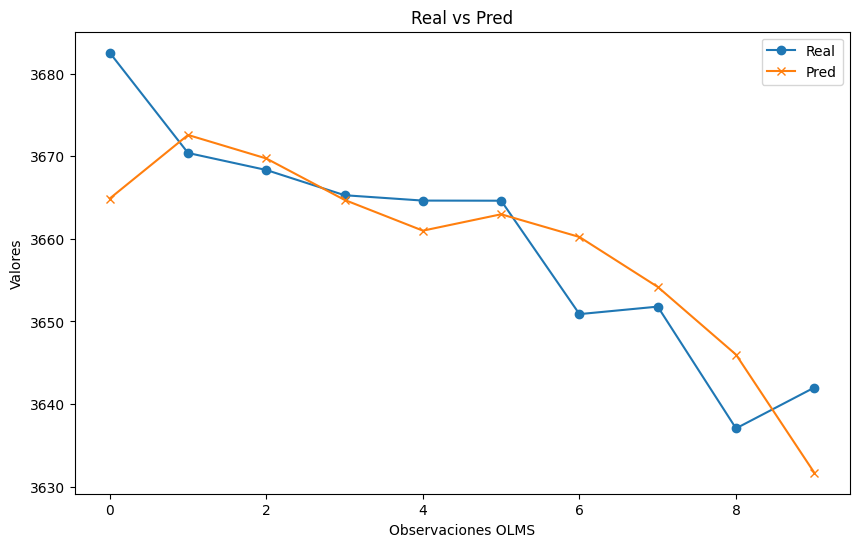

In [35]:
# Extraer los valores 'real' y 'pred' del diccionario
real_values = [value['real'] for value in estimaciones_hot.values()]
pred_values = [value['pred'] for value in estimaciones_hot.values()]

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(real_values, label='Real', marker='o')
plt.plot(pred_values, label='Pred', marker='x')

# Etiquetas y título
plt.xlabel('Observaciones OLMS')
plt.ylabel('Valores')
plt.title('Real vs Pred')
plt.legend()

# Mostrar la gráfica
plt.show()

In [36]:
estimaciones_hot

{0: {'real': 3682.52625647666,
  'pred': 3664.8764473930655,
  'rmse': 17.64980908359439},
 1: {'real': 3670.39000124754,
  'pred': 3672.569447053138,
  'rmse': 2.1794458055978794},
 2: {'real': 3668.32842509729,
  'pred': 3669.7238038707746,
  'rmse': 1.395378773484481},
 3: {'real': 3665.27459954275,
  'pred': 3664.7058203858323,
  'rmse': 0.5687791569175715},
 4: {'real': 3664.6254716928,
  'pred': 3660.9850152273375,
  'rmse': 3.6404564654626483},
 5: {'real': 3664.61077112571,
  'pred': 3662.9692882056015,
  'rmse': 1.6414829201085013},
 6: {'real': 3650.88183932508,
  'pred': 3660.2192032007392,
  'rmse': 9.337363875659321},
 7: {'real': 3651.7884696404,
  'pred': 3654.1762334100663,
  'rmse': 2.387763769666435},
 8: {'real': 3637.04763941276,
  'pred': 3645.978643686256,
  'rmse': 8.931004273496},
 9: {'real': 3641.99087267193,
  'pred': 3631.6807483885195,
  'rmse': 10.31012428341046}}

## **3.2. Modelo Tendencia con Estacionalidad**

In [173]:
def modelo_ols_estacionalidad(order,train_data,test_data):
    month_dummies = pd.get_dummies(train_data.index.month, drop_first=True).set_index(train_data.index)
    y = train_data
    x = np.linspace(1, len(train_data), len(train_data))
    X_poly = np.vander(x, N=order+1, increasing=True)
    
    X_design = sm.add_constant(np.column_stack((X_poly, month_dummies)))
    
    model = sm.OLS(y, X_design)
    model_fit = model.fit()
    
    y_test = test_data
    x_test = np.linspace(len(train_data) + 1, len(train_data) + len(test_data), len(test_data))
    X_poly_test = np.vander(x_test, N=order+1, increasing=True)
    month_dummies_test = pd.get_dummies(test_data.index.month, drop_first=True).reindex(columns=month_dummies.columns, fill_value=0)
    X_test = sm.add_constant(np.column_stack((X_poly_test, month_dummies_test)))
    y_pred_test = model_fit.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    return y_test.iloc[0].values[0], y_pred_test[0], rmse_test

In [177]:
estimaciones_ols, promedio_ols, rmse_ols = protocolo(data_producto1, 10, modelo_ols_estacionalidad,1)

In [178]:
promedio_ols

29.199727101534336

In [179]:
estimaciones_ols

{0: {'real': 3682.52625647666,
  'pred': 3680.619281290761,
  'rmse': 1.906975185898773},
 1: {'real': 3670.39000124754,
  'pred': 3662.947871724391,
  'rmse': 7.442129523149106},
 2: {'real': 3668.32842509729,
  'pred': 3643.569272339499,
  'rmse': 24.75915275779107},
 3: {'real': 3665.27459954275,
  'pred': 3636.1014762210657,
  'rmse': 29.173123321684216},
 4: {'real': 3664.6254716928,
  'pred': 3629.937994663777,
  'rmse': 34.687477029023285},
 5: {'real': 3664.61077112571,
  'pred': 3623.202749534905,
  'rmse': 41.40802159080522},
 6: {'real': 3650.88183932508,
  'pred': 3616.1106317159,
  'rmse': 34.77120760917978},
 7: {'real': 3651.7884696404,
  'pred': 3610.2424809577233,
  'rmse': 41.54598868267658},
 8: {'real': 3637.04763941276,
  'pred': 3604.566537879184,
  'rmse': 32.48110153357584},
 9: {'real': 3641.99087267193,
  'pred': 3598.1687788903705,
  'rmse': 43.82209378155949}}

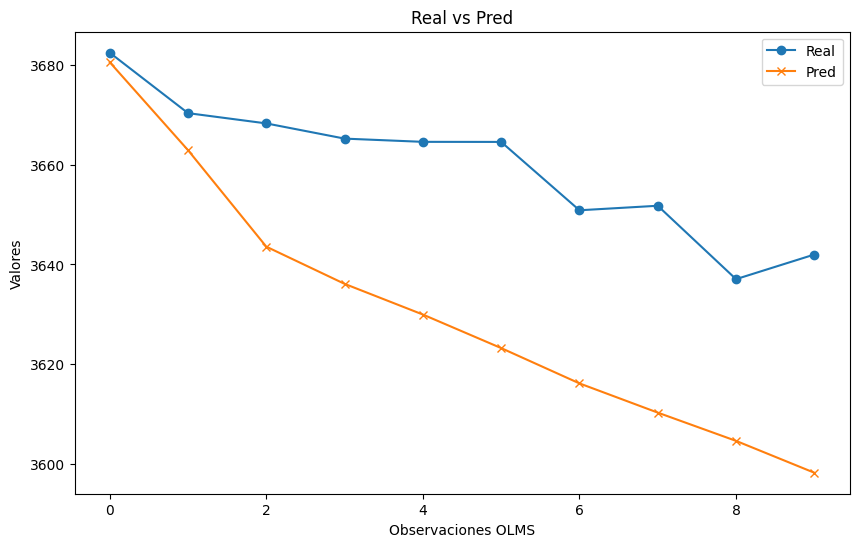

In [180]:
# Extraer los valores 'real' y 'pred' del diccionario
real_values = [value['real'] for value in estimaciones_ols.values()]
pred_values = [value['pred'] for value in estimaciones_ols.values()]

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(real_values, label='Real', marker='o')
plt.plot(pred_values, label='Pred', marker='x')

# Etiquetas y título
plt.xlabel('Observaciones OLMS')
plt.ylabel('Valores')
plt.title('Real vs Pred')
plt.legend()

# Mostrar la gráfica
plt.show()

## **3.3. Promedio Móvil**

In [ ]:
def fore_ma(datos,w,h):
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
    
  return data[-h:]

### **3.4. ARIMA**

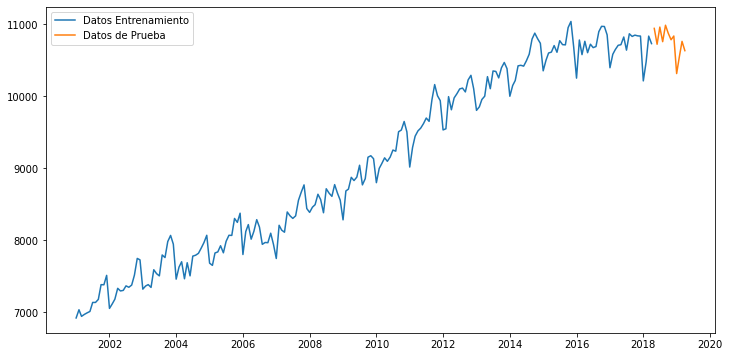

In [ ]:
train_len = 208
train_o = data[["Ocupados"]][:train_len]
test_o = data[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_o,label="Datos Entrenamiento")
plt.plot(test_o,label="Datos de Prueba")
plt.legend()
plt.show()